<a href="https://colab.research.google.com/github/brisabn/Tarefa4-MCF/blob/main/MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulações de Monte Carlo no modelo de Ising 2D

Trabalho de Métodos Computacionais de Física

Brisa do Nascimento Barbosa

Universidade Federal de Minas Gerais (UFMG)

# Parte 1 - Processo de Termalização

O processo de termalização é a fase inicial em uma simulação de Monte Carlo onde o sistema evolui de uma configuração inicial arbitrária para um estado de equilíbrio térmico. Durante a termalização, o sistema passa por vários passos de Monte Carlo, onde as configurações de spins (ou outras variáveis de estado) são ajustadas de acordo com a probabilidade de Boltzmann, permitindo que ele explore diferentes estados e minimize sua energia livre.


## Modelo de Ising
A seguir, é modelado a rede de Ising, que consiste em uma rede de spins que podem assumir valores de +1 ou -1, representando duas direções possíveis de magnetização. Cada spin interage com seus vizinhos mais próximos, e a energia do sistema é determinada pelas interações entre spins adjacentes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [3]:
def vizinhos(S):
    N = len(S)
    L= np.sqrt(len(S))
    viz = np.zeros((N,4),dtype=np.int16)

    for i in range(N):
        viz[i,0]=i+1
        if (i+1)%L == 0: viz[i,0]=i+1-L

        viz[i,1] = i+L
        if i > (N-L-1) : viz[i,1] = i+L-N

        viz[i,2] = i-1
        if i % L == 0: viz[i,2] = i-1 +L

        viz[i,3] = i-L
        if i<L : viz[i,3] = i-L+N

    return viz

@jit(nopython=True)
def energia(S, viz):
    ener = 0
    for i in range(len(S)):
        ener -= S[i] * (S[viz[i, 0]] + S[viz[i, 1]])
    return ener

## Algoritmo de Metropolis
 O algoritmo de Metroplis funciona gerando uma sequência de configurações de um sistema, aceitando ou rejeitando cada nova configuração com base na variação de energia. Começa com uma configuração inicial e, a cada passo, altera aleatoriamente o sistema e calcula a mudança na energia. Se a energia do novo estado é menor, a nova configuração é aceita; se é maior, é aceita com uma probabilidade que decresce exponencialmente com o aumento da energia. Esse processo permite explorar o espaço de estados e convergir para a distribuição de probabilidade desejada, como a distribuição de Boltzmann em sistemas térmicos.

In [4]:
# Tabela de exponenciais
@jit(nopython=True)
def expos(beta):
    ex = { -8: np.exp(8.0 * beta), -4: np.exp(4.0 * beta),
            0: 1.0,
            4: np.exp(-4.0 * beta), 8: np.exp(-8.0 * beta) }
    return ex

# Algoritmo de Metropolis
@jit(nopython=True)
def metropolis(S, viz, ex, ener, mag):
    N = len(S)
    for i in range(N):
        k = np.random.randint(N)

        h = S[viz[k, 0]] + S[viz[k, 1]] + S[viz[k, 2]] + S[viz[k, 3]]
        de = 2 * S[k] * h

        if np.random.rand() < ex[de]:
            S[k] = -S[k]
            ener += de
            mag += 2 * S[k]

    return S, ener, mag

##Funções para rodar várias simulações

A seguir, algumas funções são definidas para permitir rodar diversas simulações.

In [5]:
def multiple_simulations(L, beta, n, N_term, N_mcs):
    all_energias = []
    all_magnetizacoes = []
    last_1000_energias = []
    last_1000_magnetizacoes = []

    for i in range(n):
        energias, magnetizacoes = simulacao_termalizacao(L, beta, N_term)
        all_energias.append(energias)
        all_magnetizacoes.append(magnetizacoes)

        last_1000_energias.append(-np.array(energias)[-N_mcs:])  # Inverte o sinal da energia
        last_1000_magnetizacoes.append(np.abs(np.array(magnetizacoes)[-N_mcs:]))  # Valor absoluto da magnetização

    return (np.array(all_energias), np.array(all_magnetizacoes),
            np.array(last_1000_energias), np.array(last_1000_magnetizacoes))

In [6]:
def simulacao_termalizacao(L, beta, passos_mc):
    N = L * L
    S = np.random.choice([-1, 1], size=N).astype(np.int8)
    viz = vizinhos(S)
    ener = energia(S, viz)
    mag = np.sum(S)
    ex = expos(beta)

    energias = []
    magnetizacoes = []

    for passo in range(passos_mc):
        S, ener, mag = metropolis(S, viz, ex, ener, mag)
        energias.append(ener)
        magnetizacoes.append(mag)

    return energias, magnetizacoes

Para plotar os gráficos de energia e magnetização, fazemos o seguinte:

In [7]:
import matplotlib.pyplot as plt

def plotagem_1(all_energias, all_magnetizacoes, n):
    plt.figure(figsize=(7, 4))
    for i in range(n):
        plt.plot(all_energias[i], linewidth=0.8, alpha=0.92)
    plt.xlabel('Passos de Monte Carlo')
    plt.ylabel('Energia')
    plt.title('Energia')
    plt.show()

    plt.figure(figsize=(7, 4))
    for i in range(n):
        plt.plot(all_magnetizacoes[i], linewidth=0.8, alpha=0.92)
    plt.xlabel('Passos de Monte Carlo')
    plt.ylabel('Magnetização')
    plt.title('Magnetização')
    plt.show()

def plotagem_2(all_energias, all_magnetizacoes, n):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

    for i in range(n):
        ax1.plot(all_energias[i], linewidth=0.8, alpha=0.92)
    ax1.set_xlabel('Passos de Monte Carlo')
    ax1.set_ylabel('Energia')
    ax1.set_title('Energia')
    for i in range(n):
        ax2.plot(all_magnetizacoes[i], linewidth=0.8, alpha=0.92)
    ax2.set_xlabel('Passos de Monte Carlo')
    ax2.set_ylabel('Magnetização')
    ax2.set_title('Magnetização')

    plt.tight_layout()
    plt.show()

Testando para L=32, T=1.5.

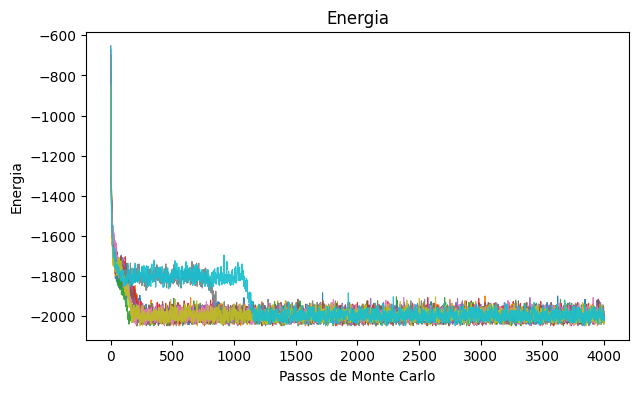

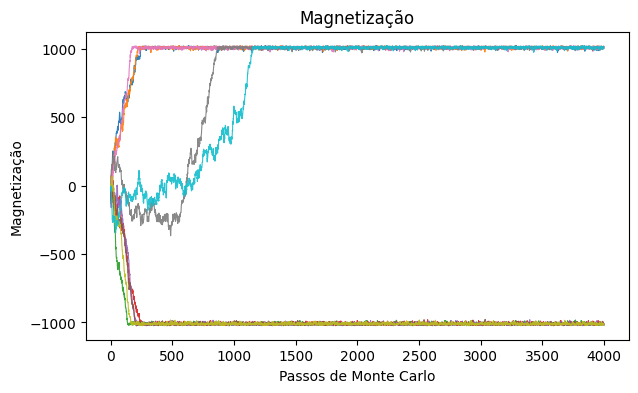

In [8]:
# Parâmetros
L = 32
T = 1.5
beta = 1 / T
passos_mc = 4000
last_mc = 1000
n = 10

# Executar múltiplas simulações
all_energias, all_magnetizacoes, last_1000_energias, last_1000_magnetizacoes = multiple_simulations(L, beta, n, passos_mc, last_mc)
plotagem_1(all_energias, all_magnetizacoes, n)

## Estimativa de erro: Block Averaging Method
Para estimar os erros estatíscos das simulações, utilizaremos o método das caixas, que consiste em dividir os dados em blocos de tamanho igual. Assim, calcula-se a média dos valores em cada bloco, e em seguida a variância dessas médias. A partir dessa variância, estima-se o erro estatístico da média geral dos dados.

In [9]:
def metodo_caixas(energias, magnetizacoes, beta, L, n):
    N = L * L
    Nmcs = len(energias)
    m = Nmcs // n

    cv_caixas = []
    chi_caixas = []
    energia_caixas = []
    magnetizacao_caixas = []

    for i in range(n):
        start_idx = i * m
        end_idx = start_idx + m

        energias_caixa = energias[start_idx:end_idx]
        magnetizacoes_caixa = magnetizacoes[start_idx:end_idx]

        if len(energias_caixa) == 0 or len(magnetizacoes_caixa) == 0:
            continue

        energias_2_caixa = energias_caixa**2
        magnetizacoes_2_caixa = magnetizacoes_caixa**2

        # Médias
        media_E_i = np.mean(energias_caixa)
        media_E2_i = np.mean(energias_2_caixa)

        media_M_i = np.mean(magnetizacoes_caixa)
        media_M2_i = np.mean(magnetizacoes_2_caixa)

        # Calor específico para a caixa i
        cv_i = (beta**2 / N) * (media_E2_i - media_E_i**2)
        cv_caixas.append(cv_i)

        # Suscetibilidade magnética para a caixa i
        chi_i = (beta / N) * (media_M2_i - media_M_i**2)
        chi_caixas.append(chi_i)

        # Energia média e magnetização média para a caixa i
        energia_caixas.append(media_E_i)
        magnetizacao_caixas.append(media_M_i)

    cv_medio = np.mean(cv_caixas)
    chi_medio = np.mean(chi_caixas)
    energia_media = np.mean(energia_caixas)
    magnetizacao_media = np.mean(magnetizacao_caixas)

    erro_cv = np.sqrt(np.sum((cv_caixas - cv_medio)**2) / (n * (n - 1)))
    erro_chi = np.sqrt(np.sum((chi_caixas - chi_medio)**2) / (n * (n - 1)))
    erro_energia = np.sqrt(np.sum((energia_caixas - energia_media)**2) / (n * (n - 1)))
    erro_magnetizacao = np.sqrt(np.sum((magnetizacao_caixas - magnetizacao_media)**2) / (n * (n - 1)))

    return {
        "cv_medio": cv_medio,
        "erro_cv": erro_cv,
        "chi_medio": chi_medio,
        "erro_chi": erro_chi,
        "energia_media": energia_media,
        "erro_energia": erro_energia,
        "magnetizacao_media": magnetizacao_media,
        "erro_magnetizacao": erro_magnetizacao
    }

resultados = metodo_caixas(last_1000_energias, last_1000_magnetizacoes, beta, L, n)
print(f"Calor específico médio: {resultados['cv_medio']:.6f}, Erro: {resultados['erro_cv']:.6f}")
print(f"Suscetibilidade magnética média: {resultados['chi_medio']:.6f}, Erro: {resultados['erro_chi']:.6f}")
print(f"Energia média: {resultados['energia_media']:.6f}, Erro: {resultados['erro_energia']:.6f}")
print(f"Magnetização média: {resultados['magnetizacao_media']:.6f}, Erro: {resultados['erro_magnetizacao']:.6f}")

Calor específico médio: 0.195244, Erro: 0.004896
Suscetibilidade magnética média: 0.026768, Erro: 0.000791
Energia média: 1998.172800, Erro: 0.242833
Magnetização média: 1010.244000, Erro: 0.081952


# Parte 2 - Análise de resultados

In [11]:
def rodar(L, beta, n, passos_mc, last_mc):
    all_energias, all_magnetizacoes, last_1000_energias, last_1000_magnetizacoes = multiple_simulations(L, beta, n, passos_mc, last_mc)

    plotagem_2(all_energias, all_magnetizacoes, n)

    resultados = metodo_caixas(last_1000_energias, last_1000_magnetizacoes, beta, L, n)
    print(f"Calor específico médio: {resultados['cv_medio']:.6f}, Erro: {resultados['erro_cv']:.6f}")
    print(f"Suscetibilidade magnética média: {resultados['chi_medio']:.6f}, Erro: {resultados['erro_chi']:.6f}")
    print(f"Energia média: {resultados['energia_media']:.6f}, Erro: {resultados['erro_energia']:.6f}")
    print(f"Magnetização média: {resultados['magnetizacao_media']:.6f}, Erro: {resultados['erro_magnetizacao']:.6f}")

### 1) Critérios para escolher parâmetros
Escolhi a temperatura e o tamanho do sistema de forma a garantir condições relativamente estáveis para facilitar a comparação com outros parâmetros. T=1.5 e L=40 pareciam suficientemente ok para comparar com outros parâmeros. O número de passos de Monte Carlo foi definido em 4000, considerando um tempo ok de simulação para não demorar muito necessidade de obter dados suficientes para análise; esse número se mostrou razoável para a maioria das simulações alcançar a termalização. Para o cálculo das médias das grandezas termodinâmicas, utilizei os últimos 1000 passos, garantindo assim que os dados fossem coletados após o sistema atingir o equilíbrio.

### 2) Variação da temperatura
A seguir, gráficos do sistema mantendo em L=40 e aumentado a temperatura gradativamente entre 0.3, 0.85, 1.7, 2.3 e 3.0.

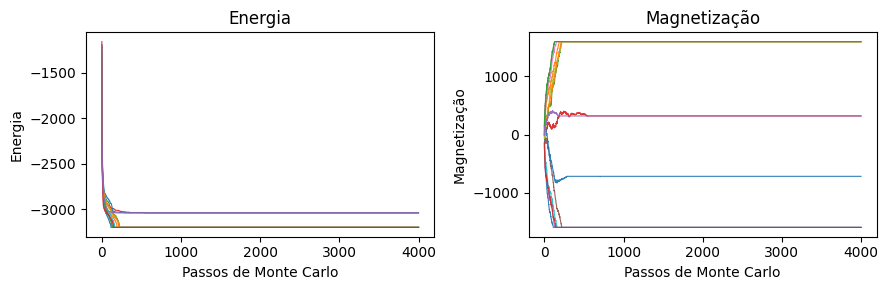

Calor específico médio: 0.000007, Erro: 0.000007
Suscetibilidade magnética média: 0.000001, Erro: 0.000001
Energia média: 3167.999733, Erro: 17.104862
Magnetização média: 1370.666800, Erro: 124.638317


In [30]:
L = 40
T = 0.3
beta = 1 / T
rodar(L, beta, 15, 4000, 1000)

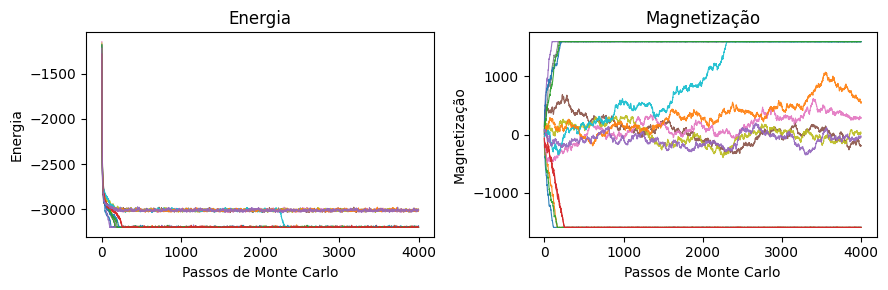

Calor específico médio: 0.023677, Erro: 0.006141
Suscetibilidade magnética média: 2.715511, Erro: 1.680565
Energia média: 3136.402400, Erro: 23.629078
Magnetização média: 1154.449067, Erro: 172.351830


In [25]:
T = 0.85
beta = 1 / T
rodar(L, beta, 15, 4000, 1000)

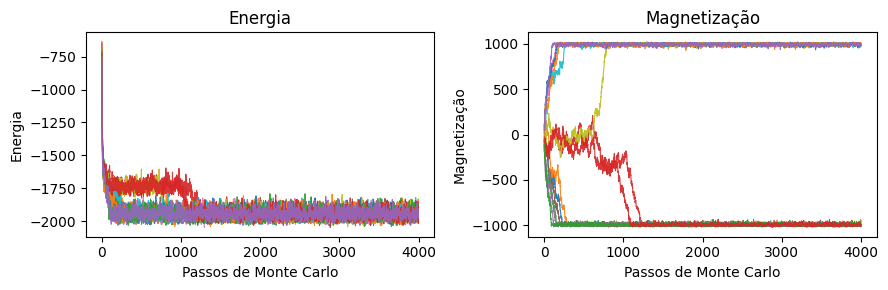

Calor específico médio: 0.337245, Erro: 0.007647
Suscetibilidade magnética média: 0.066462, Erro: 0.002046
Energia média: 1944.417333, Erro: 0.491478
Magnetização média: 993.611333, Erro: 0.186375


In [15]:
T = 1.7
beta = 1 / T
rodar(L, beta, 15, 4000, 1000)

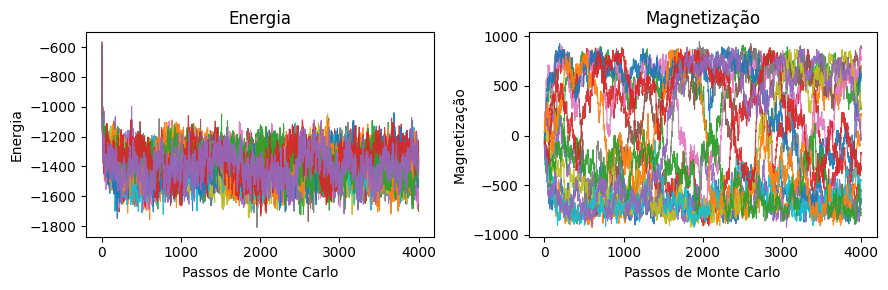

Calor específico médio: 1.527566, Erro: 0.102990
Suscetibilidade magnética média: 13.808050, Erro: 1.987609
Energia média: 1390.590667, Erro: 10.623102
Magnetização média: 526.143867, Erro: 37.958080


In [12]:
T = 2.3
beta = 1 / T
rodar(L, beta, 15, 4000, 1000)

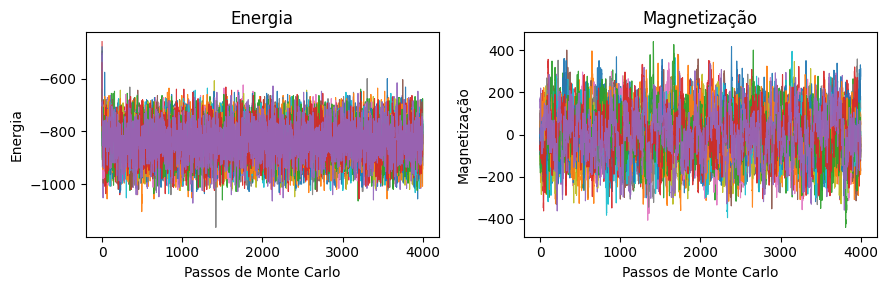

Calor específico médio: 0.391481, Erro: 0.005435
Suscetibilidade magnética média: 1.395326, Erro: 0.046013
Energia média: 834.988533, Erro: 0.969748
Magnetização média: 86.969733, Erro: 1.472001


In [14]:
T = 3.0
beta = 1 / T  # Calcula beta a partir da temperatura

rodar(L, beta, 15, 4000, 1000)

A partir de T=2.3, observa-se um aumento significativo nas flutuações da energia e da magnetização no modelo de Ising 2D. Isso indica que o sistema está próximo da temperatura crítica, onde ocorre a transição de fase entre a fase ferromagnética, em que os spins estão alinhados, e a fase paramagnética, em que os spins estão desordenados. À medida que a temperatura se aproxima da temperatura crítica, a energia média do sistema aumenta devido ao aumento da desordem térmica, e a magnetização média diminui, flutuando mais intensamente à medida que os spins começam a se desalinhar. Essas flutuações intensificadas refletem o equilíbrio dinâmico entre as configurações ordenadas e desordenadas.

Simultaneamente, o calor específico e a susceptibilidade magnética também aumentam ao aumentar a temperatura. O aumento no calor específico sugere que o sistema está absorvendo ou liberando mais energia à medida que passa pela transição de fase.


### 3) Variação do tamanho do sistema

Mantendo a temperatura em 1.5, verificamos o comportamento do sistema para os tamanho L= 24, 43, 62, 81 e 100.



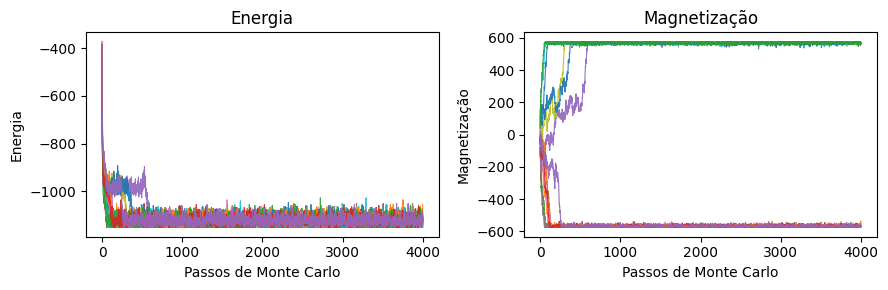

Calor específico médio: 0.203393, Erro: 0.003611
Suscetibilidade magnética média: 0.027694, Erro: 0.000672
Energia média: 1123.477333, Erro: 0.180561
Magnetização média: 568.118533, Erro: 0.055497


In [16]:
L = 24
T = 1.5
beta = 1 / T
rodar(L, beta, 15, 4000, 1000)

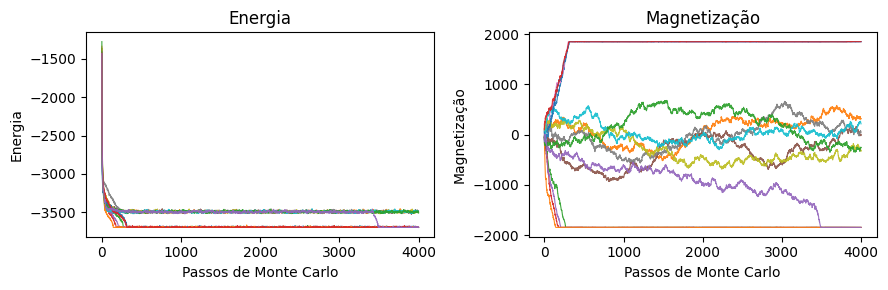

Calor específico médio: 0.502026, Erro: 0.473521
Suscetibilidade magnética média: 6.690397, Erro: 3.384628
Energia média: 3609.406667, Erro: 25.954685
Magnetização média: 1191.532933, Erro: 207.292099


In [22]:
L = 43
rodar(L, beta, 15, 4000, 1000)

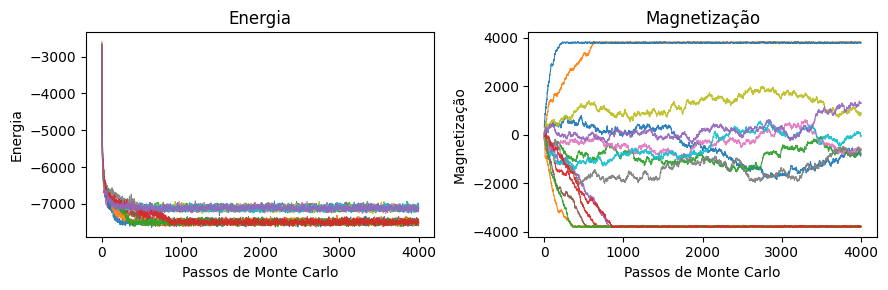

Calor específico médio: 0.216167, Erro: 0.006532
Suscetibilidade magnética média: 7.910392, Erro: 3.167084
Energia média: 7320.141600, Erro: 51.078191
Magnetização média: 2388.376667, Erro: 407.355168


In [18]:
L = 62
rodar(L, beta, 15, 4000, 1000)

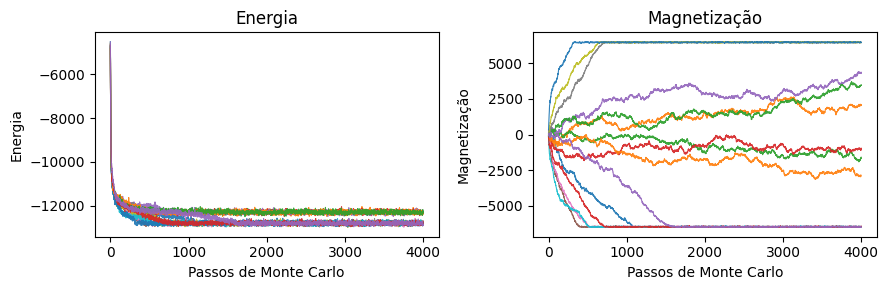

Calor específico médio: 0.208638, Erro: 0.004907
Suscetibilidade magnética média: 3.681240, Erro: 1.724613
Energia média: 12600.185600, Erro: 65.830957
Magnetização média: 4774.214933, Erro: 573.761777


In [19]:
L = 81
rodar(L, beta, 15, 4000, 1000)

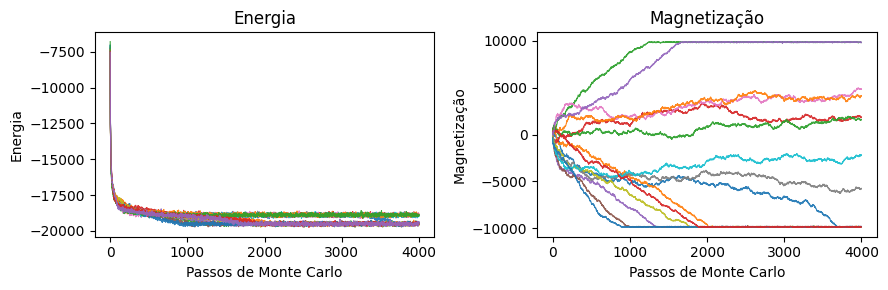

Calor específico médio: 0.400387, Erro: 0.192530
Suscetibilidade magnética média: 8.633658, Erro: 6.261466
Energia média: 19240.497333, Erro: 79.792414
Magnetização média: 7097.850933, Erro: 895.016364


In [20]:
L = 100
rodar(L, beta, 15, 4000, 1000)

A variação do tamanho do sistema no modelo revela como os efeitos de tamanho finito influenciam as propriedades termodinâmicas observadas. Para tamanhos de sistema pequenos, as flutuações são mais pronunciadas, o que pode suavizar ou ofuscar características críticas, como o pico de calor específico ou susceptibilidade magnética Isso ocorre porque sistemas menores não representam bem o comportamento de um sistema macroscópico, levando a resultados que podem variar significativamente entre diferentes simulações ou amostras. Em sistemas grandes, essas flutuações são reduzidas, e as características da transição de fase, como o surgimento de picos pronunciados, tornam-se mais evidentes, aproximando-se do que seria observado no limite termodinâmico.

### 4) Relação da temperatura com o erro
Os erros estatísticos tendem a ser maiores perto de temperaturas críticas, onde as flutuações no sistema são máximas.

Em temperaturas muito baixas e muito altas, os erros tendem a ser menores porque o sistema está em estados mais ordenados (ferromagnético) ou completamente desordenados (paramagnético), onde as flutuações são menos pronunciadas. No entanto, à medida que a temperatura se aproxima da temperatura crítica, os erros estatísticos aumentam significativamente. Isso ocorre porque, na transição de fase, o sistema experimenta grandes flutuações em energia e magnetização, refletindo a competição entre os estados ordenado e desordenado, o que dificulta a convergência das médias estatísticas.

### 5) Fases do sistema
**Fase Ferromagnética**: Em baixas temperaturas, o sistema está na fase ferromagnética, caracterizada por uma magnetização média por spin significativa. Nesta fase, a maioria dos spins está alinhada na mesma direção, resultando em uma configuração ordenada e uma energia por spin relativamente baixa. Esta ordenação ocorre porque, em baixas temperaturas, a energia térmica é insuficiente para superar as interações de troca que favorecem o alinhamento dos spins. A susceptibilidade magnética é relativamente baixa, pois pequenas variações no campo externo não afetam significativamente a magnetização.

**Fase Paramagnética**: Em altas temperaturas, o sistema entra na fase paramagnética, onde a magnetização média por spin é zero ou muito próxima de zero. Nesta fase, os spins estão orientados aleatoriamente devido à alta energia térmica, que supera as interações de troca e desorganiza o sistema, resultando em uma configuração desordenada. A energia por spin é mais alta do que na fase ferromagnética, e a susceptibilidade magnética é baixa, exceto em torno da temperatura crítica, onde atinge um pico devido às grandes flutuações e à alta sensibilidade a pequenas mudanças no campo externo.



### 6) Estimação da temperatura
Como dito nas análises acima, a temperatura de transição parece estar em torno de T=2.3.